In [3]:
import numpy as np
import pandas as pd
import pickle 

import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sns


# Loading Data

In [4]:
def load_pickle_data(path:str)->pd.DataFrame:
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

In [5]:
df = load_pickle_data("data/df_train.pkl")
embeddings = df["business_description_embedding"].apply(ast.literal_eval).tolist()

In [6]:
df.head(3)

,id,industry,business_description_embedding
38532,42576,Banks,"[0.03411475,-0.03753958,0.023233214,-0.0017205..."
19838,21752,Materials,"[-0.025557408,0.0636078,-0.01350581,-0.0180223..."
904,804,Commercial & Professional Services,"[0.033574868,-0.020379327,-0.03221274,-0.01133..."


# Transforming Data (Label Encoding)

### Tasks:
- Use the scikit-learn label encoder to encode the industry names
- Check if all classes contained in the validation set are also in the training set

In [7]:
df_train, df_val = train_test_split(df, test_size= 0.2, random_state=42)

X_train = df_train.business_description_embedding.apply(ast.literal_eval).tolist()
X_train = np.array(X_train)

X_val = df_val.business_description_embedding.apply(ast.literal_eval).tolist()
X_val = np.array(X_val)

In [8]:
# Fit the label encoder to the classes (industry names)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['industry'])
y_val = label_encoder.transform(df_val['industry'])

In [9]:
# Check if all classes contained in the validation set are also in the training set
assert set(y_val).issubset(set(y_train)), "Validation set contains unseen classes!"

#

# Visualize the data

### Tasks:
- Are certain classes over- or under represented? Either produce a table or a plot to show this.
- Inspect whether there is signal in the business description embeddings:
    - Perform a PCA to project data into 2 dimensions
    - Plot projected data in Scatterplot and color based on classes
    - Provide a description of what you see and judge whether there is signal in the data that allows industry classification

Important: Ensure that your plots have proper axis descriptions and titles. Style the plots so that differences in class distributions are visible (e.g. scatter size, transparency, color, etc.)

### Class distribution

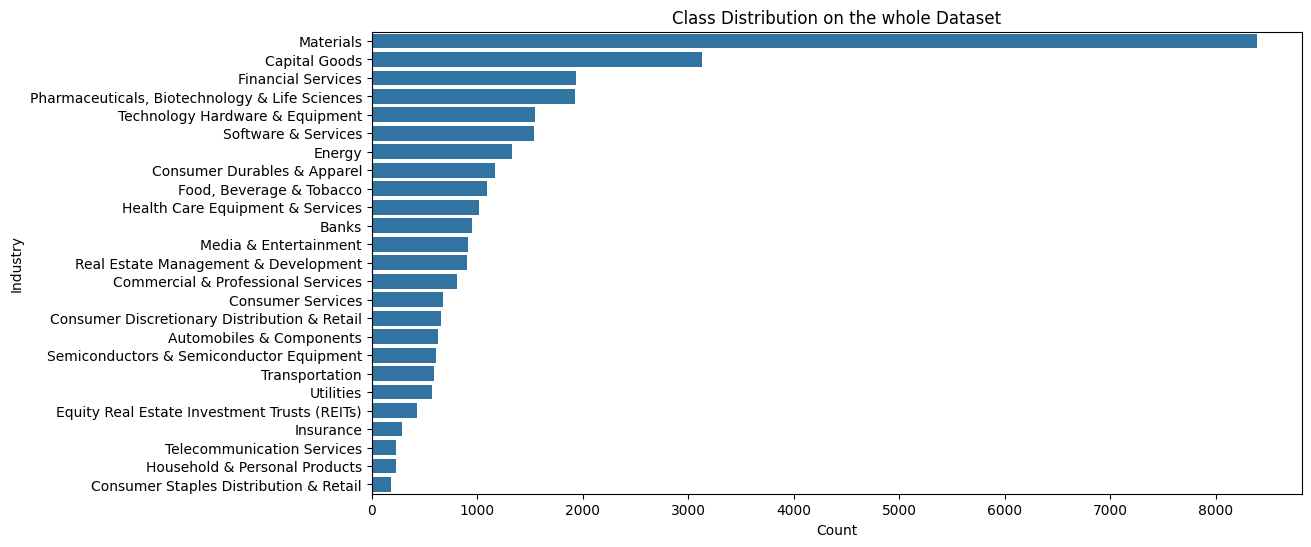

In [10]:
# Plot the class distribution or provide a table that shows how many times each class (industry) appears
plt.figure(figsize=(12, 6))

sns.countplot(y=df['industry'], order=df['industry'].value_counts().index)
plt.title('Class Distribution on the whole Dataset')
plt.xlabel('Count')
plt.ylabel('Industry')
plt.show() 

### Describe your findings

Based on the class distribution plot, we can observe that certain industries are significantly overrepresented in the dataset (Materials and Capital Goods), while others have very few samples (Consumer Staples Distribution & Retail, Household & Personal Products, Insurance and Telecommunication Services). This imbalance could potentially affect the performance of classification models, as they may become biased towards the majority classes. It is important to consider techniques such as resampling or class weighting to address this issue during model training.

### PCA - Dimensionality reduction and visualization

Optimal Dimensionality Reduction Analysis:
Original dimensionality: 768

To retain 80% variance:
  → Need 80 components
  → Compression: 89.6% reduction
  → Actual variance retained: 80.02%

To retain 85% variance:
  → Need 109 components
  → Compression: 85.8% reduction
  → Actual variance retained: 85.09%

To retain 90% variance:
  → Need 151 components
  → Compression: 80.3% reduction
  → Actual variance retained: 90.07%

To retain 95% variance:
  → Need 224 components
  → Compression: 70.8% reduction
  → Actual variance retained: 95.02%

To retain 99% variance:
  → Need 425 components
  → Compression: 44.7% reduction
  → Actual variance retained: 99.00%



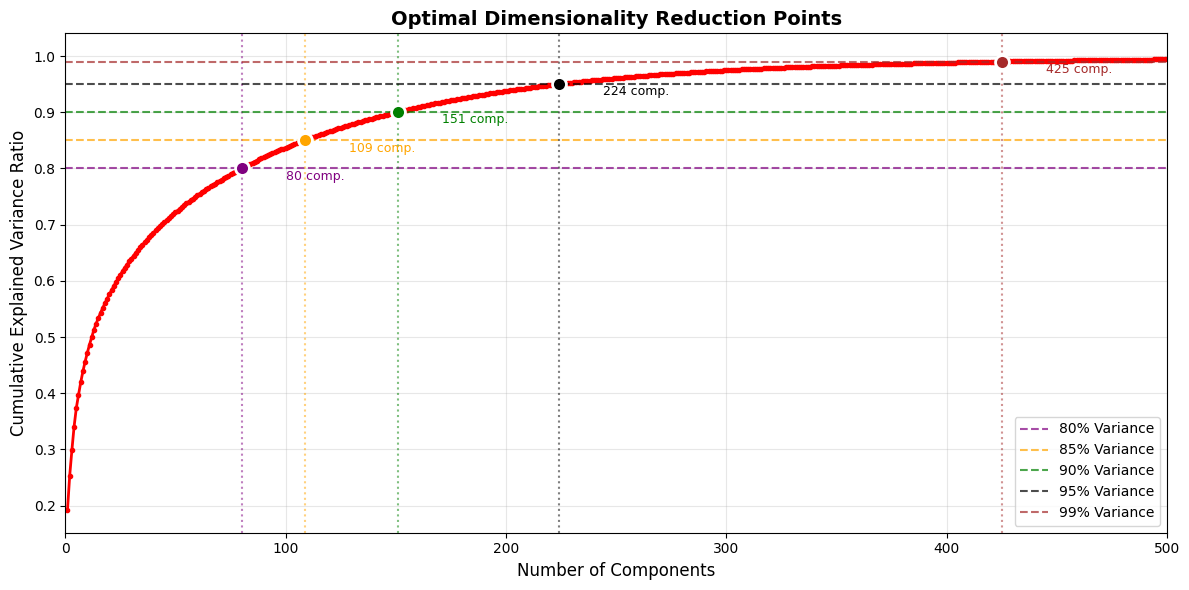

In [11]:
# Perform PCA and plot the projected data. Color the scatter plot based on the classes
pca = PCA()
pca.fit(embeddings)

# Find optimal number of components for different variance thresholds
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find components needed for different variance levels
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
print("Optimal Dimensionality Reduction Analysis:")
print("=" * 60)
print(f"Original dimensionality: {len(pca.explained_variance_ratio_)}")
print()

for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    compression_ratio = (1 - n_components / len(pca.explained_variance_ratio_)) * 100
    print(f"To retain {threshold*100:.0f}% variance:")
    print(f"  → Need {n_components} components")
    print(f"  → Compression: {compression_ratio:.1f}% reduction")
    print(f"  → Actual variance retained: {cumulative_variance[n_components-1]*100:.2f}%")
    print()

# Visualization: Mark optimal points on the cumulative plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2, markersize=3)

colors = ['purple', 'orange', 'green', 'black', 'brown']
for threshold, color in zip(variance_thresholds, colors):
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=f'{threshold*100:.0f}% Variance')
    plt.axvline(x=n_components, color=color, linestyle=':', alpha=0.5)
    plt.plot(n_components, threshold, 'o', color=color, markersize=10, markeredgecolor='white', markeredgewidth=2)
    plt.text(n_components + 20, threshold - 0.02, f'{n_components} comp.', fontsize=9, color=color)

plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.title('Optimal Dimensionality Reduction Points', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, min(500, len(cumulative_variance)))  
plt.tight_layout()
plt.show()

### Dimensionality reduction with PCA

From the plot above we can see that to retain 90% of the variance in the data, we need to keep around 100 principal components. This indicates that the original 768-dimensional embeddings can be effectively reduced to a lower-dimensional space while still preserving most of the information. Reducing the dimensionality can help improve computational efficiency and potentially enhance the performance of machine learning models by eliminating noise and redundant features as well as boost model performance and interpretability. This also means that the embeddings contain a lot of redundant information.

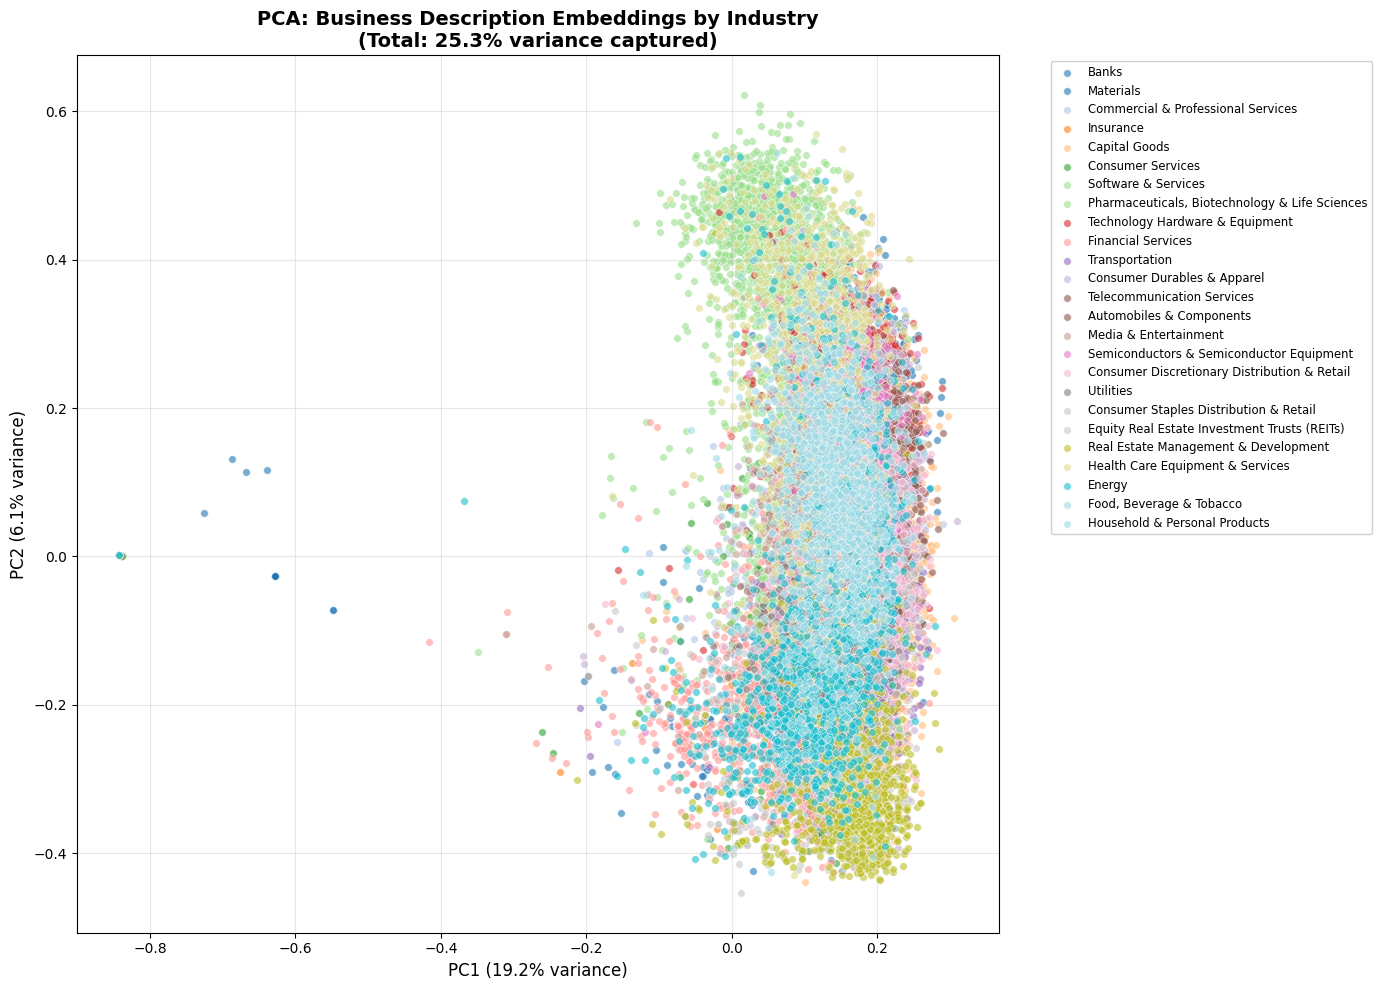

PC1 variance: 19.23%
PC2 variance: 6.08%
Total variance captured in 2D: 25.32%

This means we're losing 74.68% of information


In [12]:
# Fit PCA with only 2 components for efficiency
pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(embeddings)

# Create the scatter plot
plt.figure(figsize=(14, 10))

# Get unique industries and create a color palette
unique_industries = df['industry'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_industries)))

# Create scatter plot with different colors for each industry
for i, industry in enumerate(unique_industries):
    mask = df['industry'] == industry
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=[colors[i]], label=industry, alpha=0.6, s=30, edgecolors='w', linewidth=0.5)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'PCA: Business Description Embeddings by Industry\n(Total: {pca_2d.explained_variance_ratio_.sum():.1%} variance captured)', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"PC1 variance: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"PC2 variance: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"Total variance captured in 2D: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"\nThis means we're losing {1 - pca_2d.explained_variance_ratio_.sum():.2%} of information")

### Scatter plot of PCA projected data

Based on the PCA scatter plot, we can observe that there is some clustering of data points based on their industry classes, indicating that the business description embeddings do contain some signal that can be used for industry classification. However, there is also a significant amount of overlap between different classes, suggesting that the embeddings may not be perfectly separable in this 2D space. This overlap could pose challenges for classification models, as they may struggle to distinguish between certain industries. Overall, while there is some signal in the data, further analysis and potentially more advanced techniques may be needed to effectively classify industries based on these embeddings. One approach could be to reduce the dimensions based on the explained variance ratio and then apply clustering algorithms to identify distinct groups within the data. This could help to better understand the underlying structure of the embeddings and potentially improve classification performance.

# Fitting and comparing Classifier Models

### Tasks:
- Split the data into train and validation data
- Encode the industry labels using LabelEncoder (scikit-learn)
- Fit a LogisticRegression and a kNN-classifier
- Compare the performance of both models:
    - Compute Accuracy and F1 score
        - Interpret the scores: Explain how they are computed and judge if your model performs well
        - Analyze the classification errors: 
            - Do the errors correlate with how well classes are represented?
            - Which industries does the model identify well and which seem to be similar?
    - Plot a confusion matrix for both models (combine scikit-learn confusion matrix and seaborn heatmap plot)
    - Do both models misclassify the same examples?

Import: Use proper axis labels for the plots! 

In [13]:
# Reduce to 90% variance (approximately 151 components based on the PCA analysis)
pca_90 = PCA(n_components=0.90, random_state=42)  
X_train_reduced = pca_90.fit_transform(X_train)
X_val_reduced = pca_90.transform(X_val)

In [14]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model.fit(X_train_reduced, y_train)

Training Logistic Regression...


Training Logistic Regression...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# Train kNN Classifier
print("Training kNN Classifier...")
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',  
    metric='cosine'  
)
knn_model.fit(X_train_reduced, y_train)

Training kNN Classifier...


,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,None


In [15]:
from sklearn.model_selection import cross_val_score
import math

# Define range based on dataset
n_samples = len(X_train_reduced)
k_max = min(int(math.sqrt(n_samples)), 21)  # Reduced upper limit
k_range = range(3, k_max, 2)  # Odd numbers only

print(f"Testing k values from 3 to {k_max-1}...")
print("Using sequential cross-validation to avoid memory issues...\n")

# Cross-validation with memory-safe settings
cv_results = []
for k in k_range:
    print(f"  Testing k={k}...", end=" ")
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='cosine',
        n_jobs=1  # CRITICAL: Use single core to prevent memory overflow
    )
    # 3-fold cross-validation (fewer folds = less memory)
    scores = cross_val_score(
        knn, X_train_reduced, y_train, 
        cv=3,  # Reduced from 5 to 3 folds to save memory
        scoring='f1_macro', 
        n_jobs=1  # CRITICAL: Sequential processing only
    )
    cv_results.append({
        'k': k,
        'mean_f1': scores.mean(),
        'std_f1': scores.std()
    })
    print(f"F1 = {scores.mean():.4f} (±{scores.std():.4f})")
    
# Convert to DataFrame for easy analysis
results_df = pd.DataFrame(cv_results)
results_df = results_df.sort_values('mean_f1', ascending=False)

print("\n" + "="*60)
print("Top 5 k values by cross-validation F1 score:")
print("="*60)
print(results_df.head().to_string(index=False))

# Select best k
best_k = int(results_df.iloc[0]['k'])
best_f1 = results_df.iloc[0]['mean_f1']

print("\n" + "="*60)
print(f"Optimal k: {best_k} (CV F1: {best_f1:.4f})")
print("="*60)

# Train final model with optimal k
print(f"\nTraining final kNN with k={best_k}...")
knn_model = KNeighborsClassifier(
    n_neighbors=best_k,
    weights='distance',  
    metric='cosine',
    n_jobs=1
)
knn_model.fit(X_train_reduced, y_train)
print("kNN training complete.")

Testing k values from 3 to 20...
Using sequential cross-validation to avoid memory issues...

  Testing k=3... F1 = 0.6739 (±0.0041)
  Testing k=5... F1 = 0.6739 (±0.0041)
  Testing k=5... F1 = 0.6922 (±0.0055)
  Testing k=7... F1 = 0.6922 (±0.0055)
  Testing k=7... F1 = 0.6955 (±0.0084)
  Testing k=9... F1 = 0.6955 (±0.0084)
  Testing k=9... F1 = 0.6955 (±0.0099)
  Testing k=11... F1 = 0.6955 (±0.0099)
  Testing k=11... F1 = 0.6980 (±0.0094)
  Testing k=13... F1 = 0.6980 (±0.0094)
  Testing k=13... F1 = 0.6990 (±0.0092)
  Testing k=15... F1 = 0.6990 (±0.0092)
  Testing k=15... F1 = 0.6976 (±0.0095)
  Testing k=17... F1 = 0.6976 (±0.0095)
  Testing k=17... F1 = 0.6979 (±0.0094)
  Testing k=19... F1 = 0.6979 (±0.0094)
  Testing k=19... F1 = 0.6961 (±0.0086)

Top 5 k values by cross-validation F1 score:
 k  mean_f1   std_f1
13 0.698980 0.009239
11 0.698041 0.009418
17 0.697933 0.009391
15 0.697635 0.009533
19 0.696085 0.008584

Optimal k: 13 (CV F1: 0.6990)

Training final kNN with k=13.

In [16]:
# Predictions
y_pred_lr = lr_model.predict(X_val_reduced)
y_pred_knn = knn_model.predict(X_val_reduced)

In [17]:
# Compute metrics
print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_f1_macro = f1_score(y_val, y_pred_lr, average='macro')
lr_f1_weighted = f1_score(y_val, y_pred_lr, average='weighted')

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score (Macro): {lr_f1_macro:.4f}")
print(f"F1 Score (Weighted): {lr_f1_weighted:.4f}")

print("\n" + "="*60)
print("kNN RESULTS")
print("="*60)
knn_accuracy = accuracy_score(y_val, y_pred_knn)
knn_f1_macro = f1_score(y_val, y_pred_knn, average='macro')
knn_f1_weighted = f1_score(y_val, y_pred_knn, average='weighted')

print(f"Accuracy: {knn_accuracy:.4f}")
print(f"F1 Score (Macro): {knn_f1_macro:.4f}")
print(f"F1 Score (Weighted): {knn_f1_weighted:.4f}")


LOGISTIC REGRESSION RESULTS
Accuracy: 0.7364
F1 Score (Macro): 0.6819
F1 Score (Weighted): 0.7398

kNN RESULTS
Accuracy: 0.7758
F1 Score (Macro): 0.7039
F1 Score (Weighted): 0.7697


### Model Evaluation

We rely on the F1 Macro score to evaluate the model performance. The F1 Macro score is the unweighted mean of the F1 scores for each class, treating all classes equally regardless of their support (number of true instances for each class). This metric is particularly useful in scenarios with imbalanced class distributions, as it ensures that the performance on minority classes is given equal importance as that on majority classes.

F1 Macro formula:
F1 Macro = (1/C) * Σ (2 * (precision_i * recall_i) / (precision_i + recall_i))
where C is the number of classes, and precision_i and recall_i are the precision and recall for class i.

Looking at the confusion matrices, there's a clear correlation between classification errors and class representation:

Well-represented classes (Materials, Capital Goods) show higher diagonal values (better accuracy)
Under-represented classes (Consumer Staples Distribution & Retail, Insurance, Telecommunication Services) show poor performance with many off-diagonal predictions
This suggests that the model's performance is not only influenced by its accuracy but also by how it handles class imbalance. The model tends to misclassify instances from minority classes into majority classes, indicating a bias towards the latter.

Both models perform relatively well on:

Materials: High diagonal values (~60-70%)
Capital Goods: Decent performance (~40-50%)
Commercial & Professional Services: Moderate success

Both models struggle to distinguish between:

Financial Services and Commercial & Professional Services
Technology Hardware & Equipment and Semiconductors & Semiconductor Equipment
Consumer Discretionary Distribution & Retail and Consumer Staples Distribution & Retail
Energy companies often misclassified as Materials or Utilities

Comparing the two confusion matrices, both models show:

Similar error patterns for under-represented classes
Both struggle with the same industry pairs
kNN appears slightly more prone to spreading predictions across multiple classes
Logistic Regression tends to be more decisive but sometimes wrong

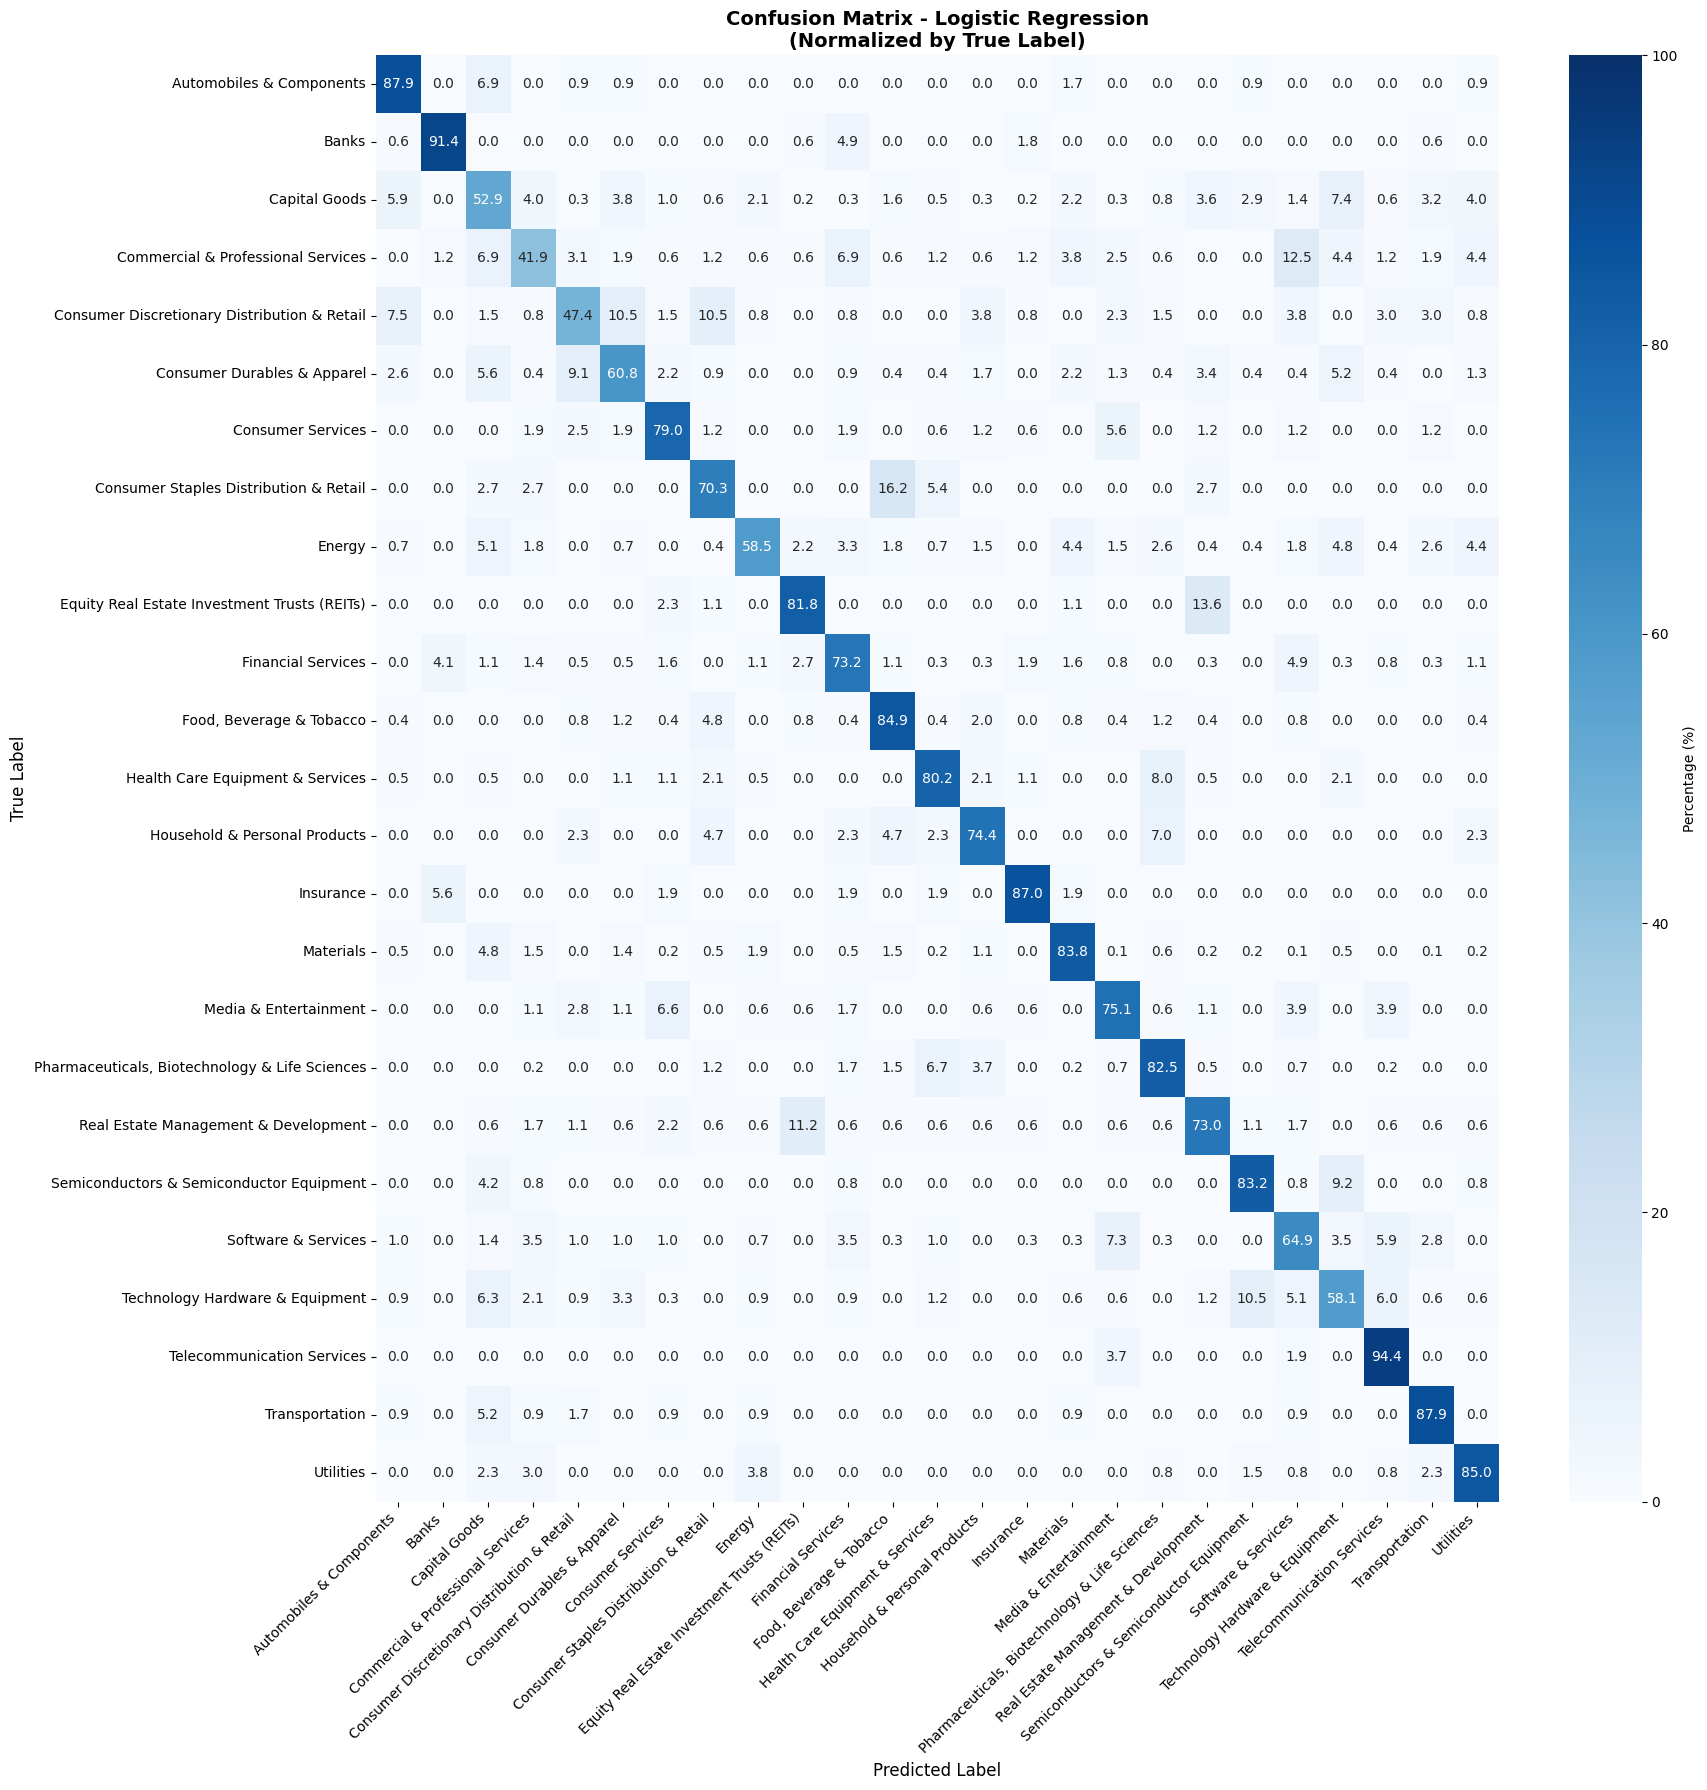

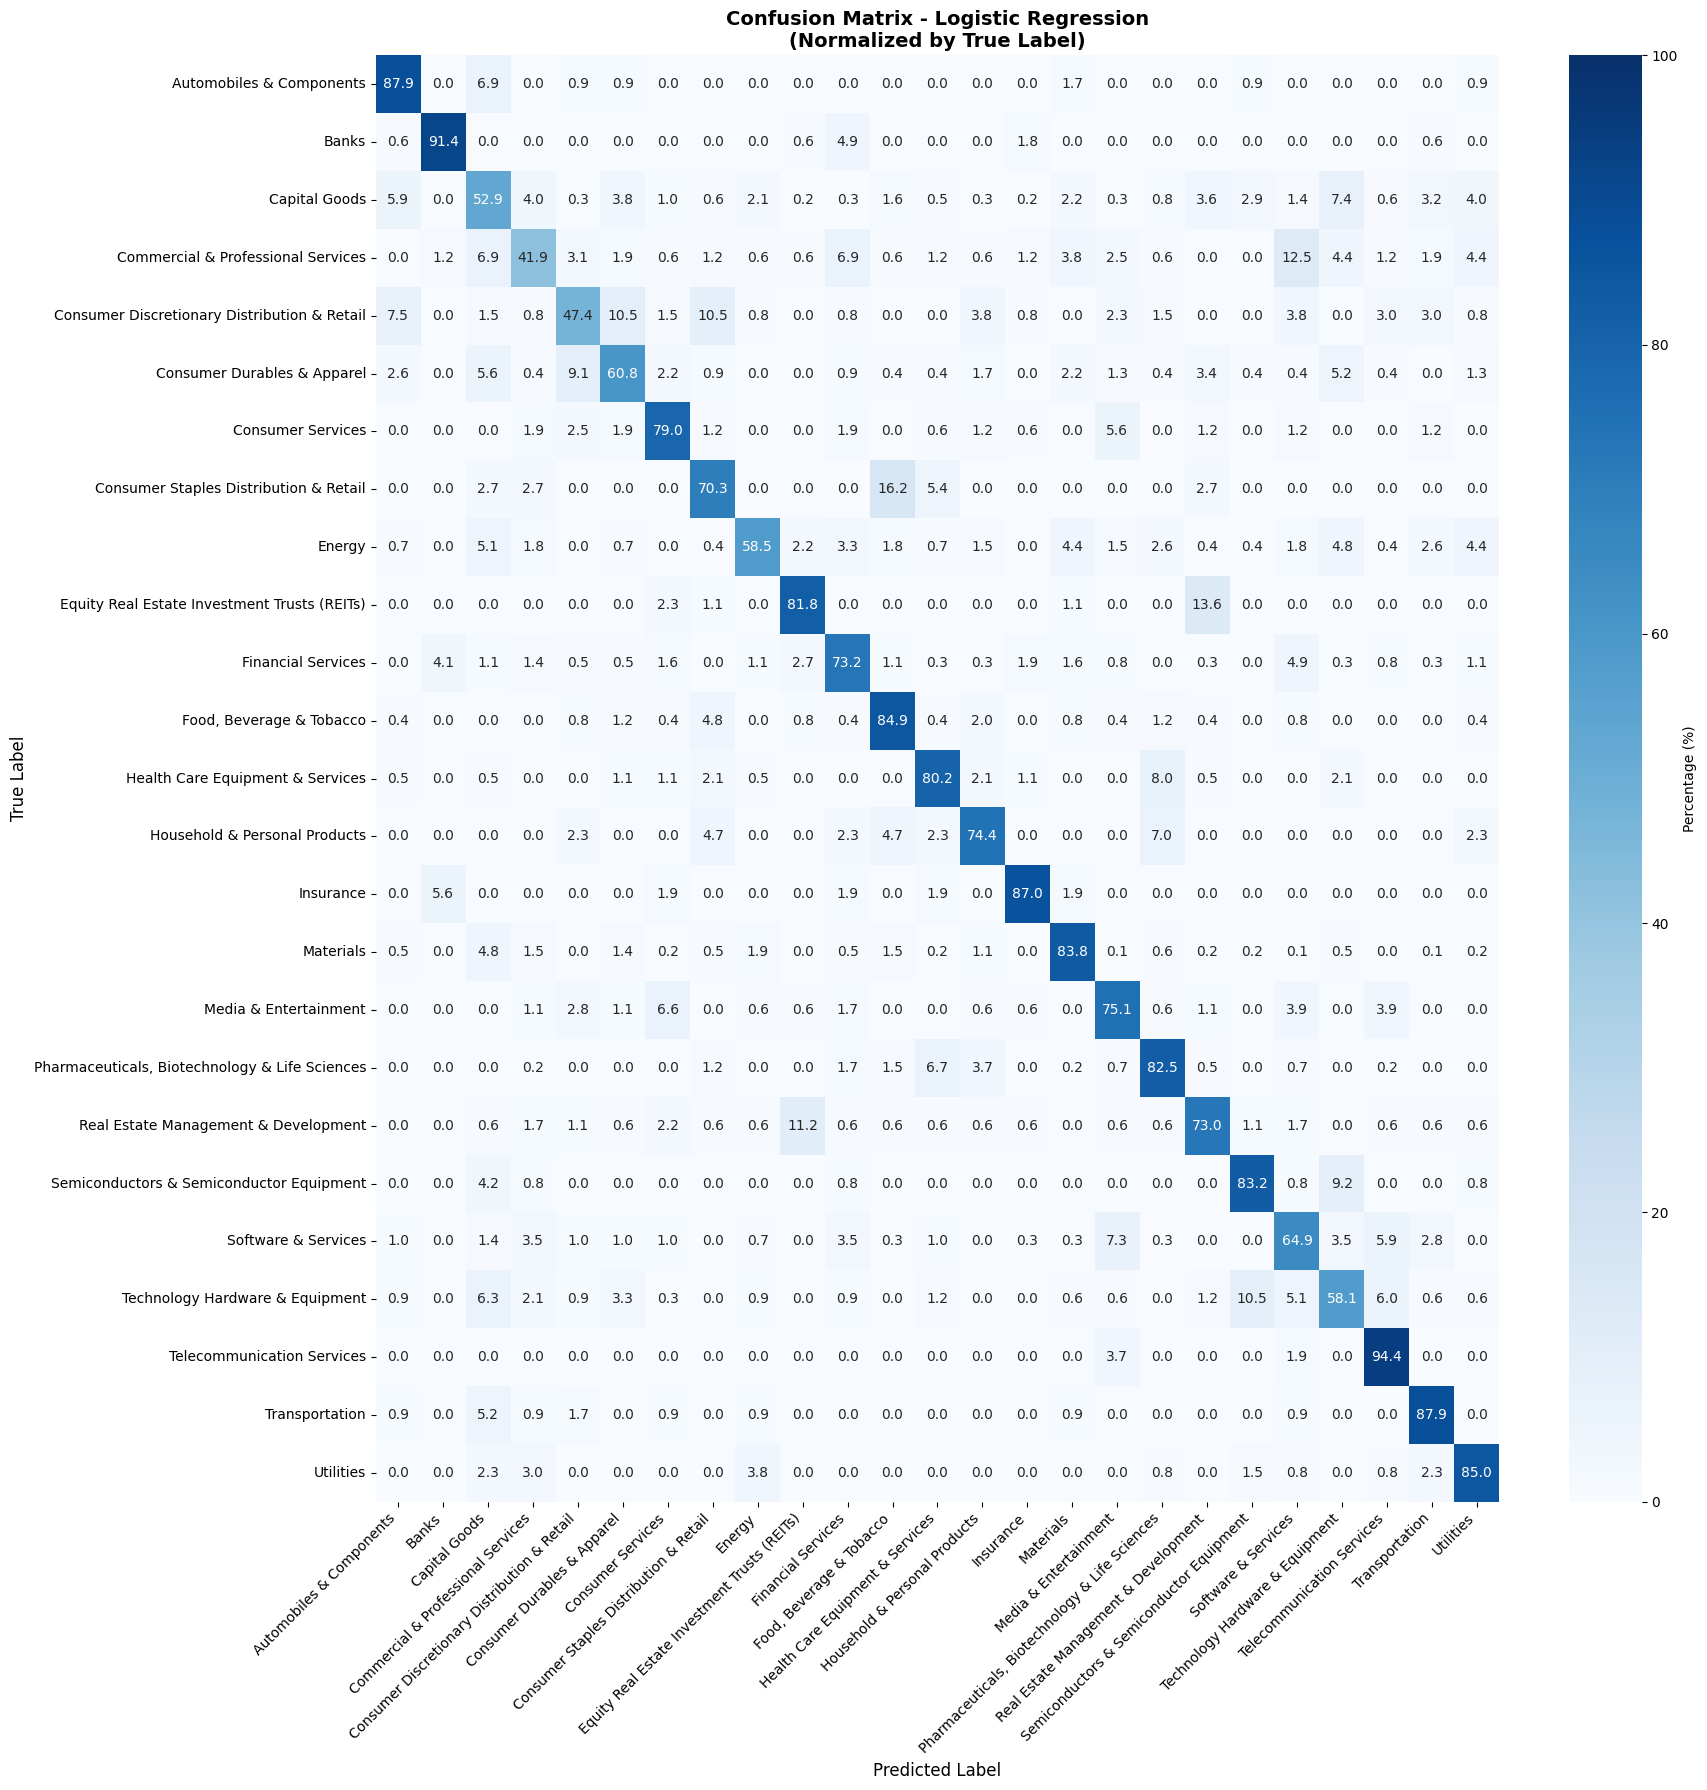

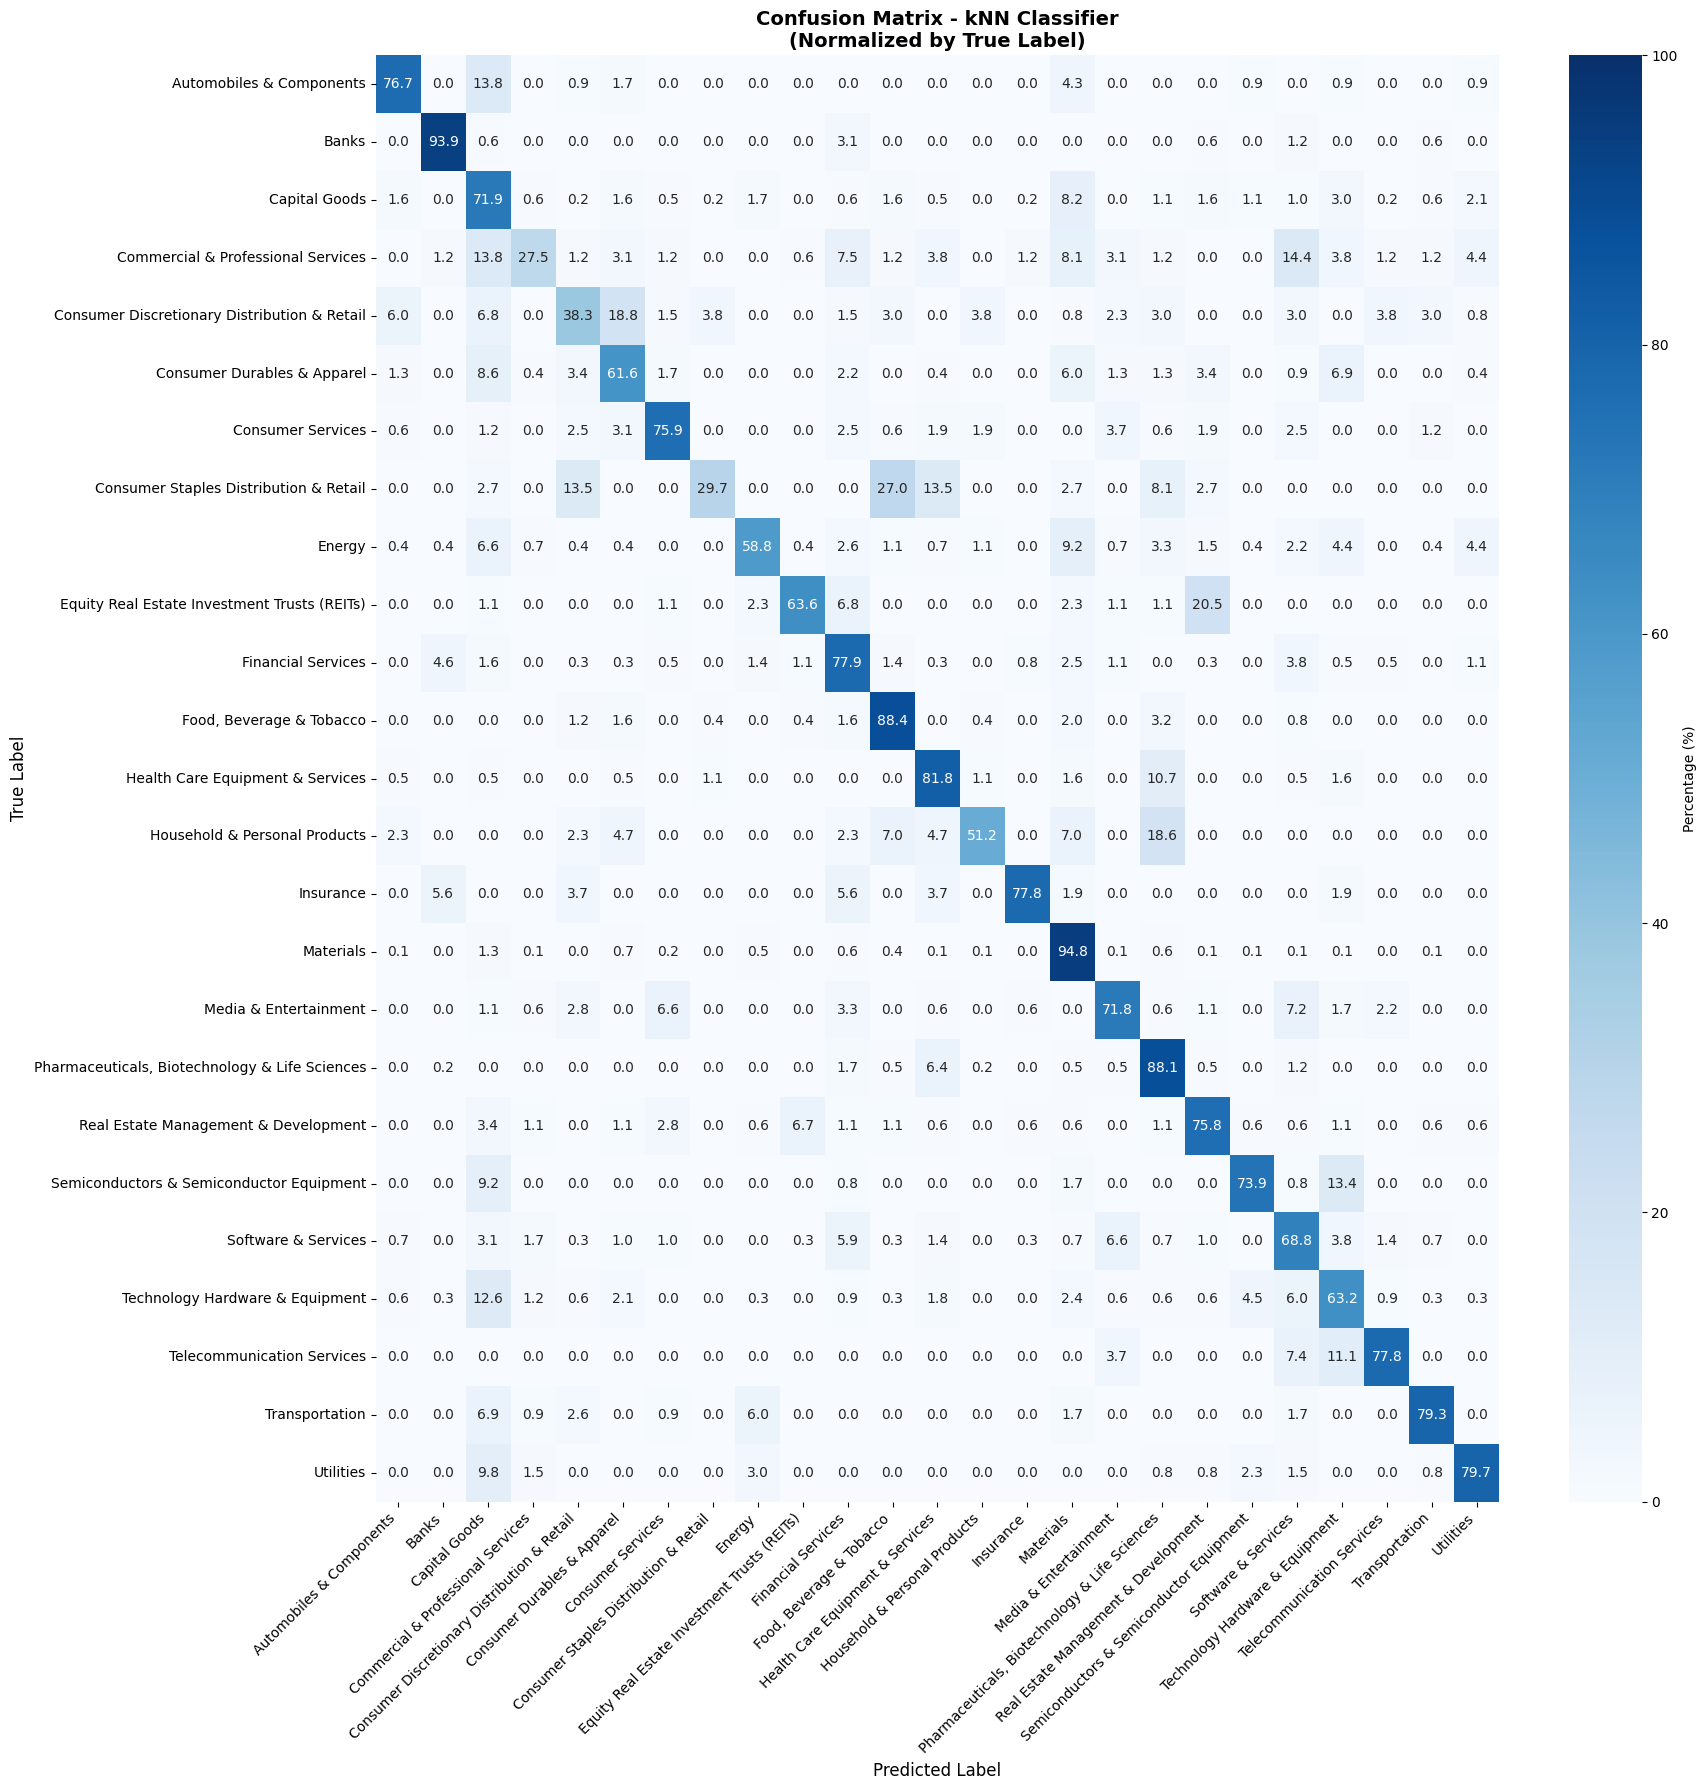

In [18]:
def plot_confusion_matrix_sklearn(y_true, y_pred, title, label_encoder):
    """Plot confusion matrix using sklearn's normalize parameter"""
    
    # Calculate normalized confusion matrix
    cm_percent = confusion_matrix(y_true, y_pred, normalize='true') * 100
    
    plt.figure(figsize=(18, 18))
    sns.heatmap(
        cm_percent, 
        annot=True, 
        fmt='.1f', 
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cbar_kws={'label': 'Percentage (%)'},
        vmin=0,
        vmax=100
    )
    plt.title(f'{title}\n(Normalized by True Label)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix_sklearn(y_val, y_pred_lr, 
                     'Confusion Matrix - Logistic Regression', 
                     label_encoder)

plot_confusion_matrix_sklearn(y_val, y_pred_knn, 
                     'Confusion Matrix - kNN Classifier', 
                     label_encoder)

# Optional: Confidence Weighted Prediction

## Deliverables:

- Provide a notebook with the implementation and training of an industry classifier model
- The model shall output the industry classification and its confidence as a tuple of vectors $(\hat{y}_{pred}, \hat{y}_{confidence})$
- The confidence score must be between 0 and 1, $\hat{y}_{confidence} [i] \in [0,1]$
- Your model will be evaluated on a private test set
- The designing the confidence score is your task. You may use p-values, a voting mechanism of multiple models, or other techniques
- Another option is to add more features, e.g. financial data, to X

In [19]:
def confidence_weighted_f1(y_true, y_pred, confidence):
    # Weight all predictions, not just positives
    weighted_tp = np.sum(confidence * (y_pred == 1) * (y_true == 1))
    weighted_fp = np.sum(confidence * (y_pred == 1) * (y_true == 0))
    weighted_fn = np.sum(confidence * (y_pred == 0) * (y_true == 1))
    
    precision = weighted_tp / (weighted_tp + weighted_fp) if (weighted_tp + weighted_fp) > 0 else 0
    recall = weighted_tp / (weighted_tp + weighted_fn) if (weighted_tp + weighted_fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [20]:
import numpy as np
import pandas as pd
import ast
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [21]:
class AdvancedFinancialFeatureProcessor:
    """
    Advanced feature processor with industry-aware imputation and enhanced feature engineering
    """
    
    def __init__(self, features_to_use, outlier_method='iqr', outlier_threshold=3.0):
        """
        Parameters:
        -----------
        features_to_use : list
            List of financial features to use
        outlier_method : str
            Method for outlier detection ('iqr' or 'percentile')
        outlier_threshold : float
            Threshold for outlier removal (3.0 = lenient)
        """
        self.features_to_use = features_to_use
        self.outlier_method = outlier_method
        self.outlier_threshold = outlier_threshold
        
        # Statistical storage
        self.outlier_bounds = {}
        self.industry_stats = {}
        self.global_stats = {}
        self.scaler = None
        
    def fit(self, df_financial, industries=None):
        """
        Fit the processor on training data with industry awareness
        """
        print("Fitting AdvancedFinancialFeatureProcessor with industry-aware imputation...")
        
        # Step 1: Calculate global statistics first (for fallback)
        for feature in self.features_to_use:
            valid_values = df_financial[feature].dropna()
            if len(valid_values) > 0:
                self.global_stats[feature] = {
                    'median': valid_values.median(),
                    'mean': valid_values.mean()
                }
        
        # Step 2: Calculate industry-specific statistics
        if industries is not None:
            self._calculate_industry_stats(df_financial, industries)
            df_financial_imputed = self._industry_aware_impute(df_financial.copy(), industries)
        else:
            # Fallback to global imputation if no industry info
            df_financial_imputed = self._global_impute(df_financial.copy())
        
        # Step 3: Create enhanced feature matrix
        feature_matrix = self._create_enhanced_features(df_financial_imputed)
        
        # Step 4: Handle any remaining NaN/Inf in engineered features
        feature_matrix = self._simple_impute_engineered_features(feature_matrix)
        
        # Step 5: Calculate outlier bounds per feature
        for j, feature in enumerate(self._get_all_feature_names()):
            valid_values = feature_matrix[:, j]
            valid_values = valid_values[~np.isnan(valid_values) & ~np.isinf(valid_values)]
            self.outlier_bounds[feature] = self._calculate_outlier_bounds(valid_values)
        
        # Step 6: Apply outlier handling
        feature_matrix = self._handle_outliers(feature_matrix)
        
        # Step 7: Fit scaler
        self.scaler = RobustScaler()
        feature_matrix = self.scaler.fit_transform(feature_matrix)
        
        print("Fitting complete with industry-aware imputation\n")
        return feature_matrix
    
    def transform(self, df_financial, industries=None):
        """
        Transform new data using fitted statistics
        """
        if self.scaler is None:
            raise ValueError("Must call fit() before transform()")
        
        # Apply industry-aware or global imputation
        if industries is not None and self.industry_stats:
            df_financial_imputed = self._industry_aware_impute(df_financial.copy(), industries)
        else:
            df_financial_imputed = self._global_impute(df_financial.copy())
        
        # Create enhanced features
        feature_matrix = self._create_enhanced_features(df_financial_imputed)
        
        # Handle any remaining NaN/Inf
        feature_matrix = self._simple_impute_engineered_features(feature_matrix)
        
        # Handle outliers
        feature_matrix = self._handle_outliers(feature_matrix)
        
        # Scale
        feature_matrix = self.scaler.transform(feature_matrix)
        
        return feature_matrix
    
    def _calculate_industry_stats(self, df_financial, industries):
        """
        Calculate per-industry statistics for industry-aware imputation
        """
        print("  Calculating industry-specific statistics...")
        unique_industries = np.unique(industries)
        
        for industry in unique_industries:
            mask = industries == industry
            industry_data = df_financial[mask]
            
            stats = {}
            for feature in self.features_to_use:
                valid_values = industry_data[feature].dropna()
                if len(valid_values) > 0:
                    stats[feature] = {
                        'median': valid_values.median(),
                        'mean': valid_values.mean(),
                        'std': valid_values.std(),
                        'q25': valid_values.quantile(0.25),
                        'q75': valid_values.quantile(0.75)
                    }
                else:
                    stats[feature] = None
            
            self.industry_stats[industry] = stats
        
        print(f"  Calculated statistics for {len(unique_industries)} industries")
    
    def _industry_aware_impute(self, df_financial, industries):
        """
        Impute missing values using industry-specific statistics
        """
        print("  Applying industry-aware imputation...")
        imputed_count = 0
        
        for feature in self.features_to_use:
            missing_mask = df_financial[feature].isna()
            
            if missing_mask.sum() > 0:
                for industry in np.unique(industries):
                    industry_mask = industries == industry
                    industry_missing = missing_mask & industry_mask
                    
                    if industry_missing.sum() > 0:
                        # Try industry-specific median first
                        if industry in self.industry_stats and \
                           self.industry_stats[industry].get(feature) is not None:
                            impute_value = self.industry_stats[industry][feature]['median']
                        elif feature in self.global_stats:
                            # Fallback to global median
                            impute_value = self.global_stats[feature]['median']
                        else:
                            # Last resort: column median
                            impute_value = df_financial[feature].median()
                        
                        df_financial.loc[industry_missing, feature] = impute_value
                        imputed_count += industry_missing.sum()
        
        print(f"  Imputed {imputed_count} missing values using industry statistics")
        return df_financial
    
    def _global_impute(self, df_financial):
        """
        Simple global median imputation (fallback when no industry info)
        """
        for feature in self.features_to_use:
            if df_financial[feature].isna().sum() > 0:
                if feature in self.global_stats:
                    impute_value = self.global_stats[feature]['median']
                else:
                    impute_value = df_financial[feature].median()
                df_financial[feature].fillna(impute_value, inplace=True)
        return df_financial
    
    def _simple_impute_engineered_features(self, feature_matrix):
        """
        Simple imputation for engineered features (replace NaN/Inf with column median)
        This is much simpler than KNN and sufficient for engineered features
        """
        # Replace inf with NaN first
        feature_matrix = np.where(np.isinf(feature_matrix), np.nan, feature_matrix)
        
        # For each column, replace NaN with column median
        for j in range(feature_matrix.shape[1]):
            col = feature_matrix[:, j]
            if np.isnan(col).any():
                median_val = np.nanmedian(col)
                if np.isnan(median_val):  # If entire column is NaN
                    median_val = 0.0
                feature_matrix[:, j] = np.where(np.isnan(col), median_val, col)
        
        return feature_matrix
    
    def _create_enhanced_features(self, df_financial):
        """
        Create original + enhanced engineered features
        """
        features = []
        
        # Original features
        for feature in self.features_to_use:
            features.append(df_financial[feature].values)
        
        # Enhanced engineered features
        if len(self.features_to_use) >= 2:
            # ROA proxy
            if 'net_profit_margin' in self.features_to_use and 'asset_turnover' in self.features_to_use:
                roa_proxy = df_financial['net_profit_margin'] * df_financial['asset_turnover']
                features.append(roa_proxy.values)
            
            # Operating efficiency
            if 'ebitda_margin' in self.features_to_use and 'asset_turnover' in self.features_to_use:
                operating_efficiency = df_financial['ebitda_margin'] * df_financial['asset_turnover']
                features.append(operating_efficiency.values)
            
            # Margin difference
            if 'ebitda_margin' in self.features_to_use and 'net_profit_margin' in self.features_to_use:
                margin_diff = df_financial['ebitda_margin'] - df_financial['net_profit_margin']
                features.append(margin_diff.values)
            
            # Profitability consistency
            if 'ebitda_margin' in self.features_to_use and 'net_profit_margin' in self.features_to_use:
                margin_ratio = df_financial['net_profit_margin'] / (df_financial['ebitda_margin'] + 1e-6)
                features.append(margin_ratio.values)
            
            # Asset intensity
            if 'asset_turnover' in self.features_to_use:
                asset_intensity = 1.0 / (df_financial['asset_turnover'] + 1e-6)
                features.append(asset_intensity.values)
            
            # Combined efficiency score
            if all(f in self.features_to_use for f in ['net_profit_margin', 'ebitda_margin', 'asset_turnover']):
                efficiency_score = (
                    df_financial['net_profit_margin'] * 0.4 + 
                    df_financial['ebitda_margin'] * 0.3 + 
                    df_financial['asset_turnover'] * 0.3
                )
                features.append(efficiency_score.values)
        
        return np.column_stack(features)
    
    def _get_all_feature_names(self):
        """
        Get names of all features (original + engineered)
        """
        names = list(self.features_to_use)
        
        if len(self.features_to_use) >= 2:
            if 'net_profit_margin' in self.features_to_use and 'asset_turnover' in self.features_to_use:
                names.append('roa_proxy')
            if 'ebitda_margin' in self.features_to_use and 'asset_turnover' in self.features_to_use:
                names.append('operating_efficiency')
            if 'ebitda_margin' in self.features_to_use and 'net_profit_margin' in self.features_to_use:
                names.append('margin_difference')
                names.append('margin_ratio')
            if 'asset_turnover' in self.features_to_use:
                names.append('asset_intensity')
            if all(f in self.features_to_use for f in ['net_profit_margin', 'ebitda_margin', 'asset_turnover']):
                names.append('efficiency_score')
        
        return names
    
    def _calculate_outlier_bounds(self, values):
        """
        Calculate outlier bounds with lenient thresholds
        """
        if len(values) == 0:
            return {'lower': -10, 'upper': 10}
        
        if self.outlier_method == 'iqr':
            q25, q75 = np.percentile(values, [25, 75])
            iqr = q75 - q25
            lower_bound = q25 - self.outlier_threshold * iqr
            upper_bound = q75 + self.outlier_threshold * iqr
            
        elif self.outlier_method == 'percentile':
            lower_bound = np.percentile(values, 0.5)
            upper_bound = np.percentile(values, 99.5)
            
        else:
            raise ValueError(f"Unknown outlier method: {self.outlier_method}")
        
        return {'lower': lower_bound, 'upper': upper_bound}
    
    def _handle_outliers(self, feature_matrix):
        """
        Cap outliers at computed bounds
        """
        for j, feature in enumerate(self._get_all_feature_names()):
            bounds = self.outlier_bounds[feature]
            feature_matrix[:, j] = np.clip(feature_matrix[:, j], bounds['lower'], bounds['upper'])
        
        return feature_matrix

In [22]:
class HybridEnsembleClassifier:
    """
    Improved hybrid ensemble with class-aware confidence calibration
    """
    
    def __init__(self, n_classes, embedding_weight=0.55, financial_weight=0.20):
        self.n_classes = n_classes
        self.embedding_weight = embedding_weight
        self.financial_weight = financial_weight
        
        self.embedding_models = {}
        self.financial_models = {}
        self.combined_models = {}
        
        # NEW: Class-specific calibration factors
        self.class_confidence_boost = {}
        
    def fit(self, X_embeddings, X_financial, X_combined, y_train):
        """
        Train multiple model types on different feature sets
        """
        print("\n" + "="*60)
        print("Training Hybrid Ensemble Classifier")
        print("="*60)
        
        # 1. Models trained on embeddings only (increased diversity)
        print("\n[1/3] Training embedding-specialized models...")
        self._fit_model_set(self.embedding_models, X_embeddings, y_train, 
                           model_types=['lr', 'rf', 'ridge', 'extra_trees'])
        
        # 2. Models trained on financial features only
        print("\n[2/3] Training financial-specialized models...")
        self._fit_model_set(self.financial_models, X_financial, y_train,
                           model_types=['lr', 'rf', 'extra_trees'])
        
        # 3. Models trained on combined features (more models)
        print("\n[3/3] Training combined-feature models...")
        self._fit_model_set(self.combined_models, X_combined, y_train,
                        model_types=['lr', 'rf', 'extra_trees', 'svc', 'ridge'])
        
        # NEW: Calculate class-specific confidence calibration
        self._calculate_class_calibration(X_embeddings, X_financial, X_combined, y_train)
        
        print("\n" + "="*60)
        print("Training Complete!")
        print("="*60 + "\n")
        
        return self
    
    def _fit_model_set(self, model_dict, X, y, model_types):
        """
        Helper to fit a set of model types with optimized hyperparameters
        """
        if 'lr' in model_types:
            print("  - Logistic Regression (optimized)")
            lr = LogisticRegression(
                max_iter=4000, 
                random_state=42, 
                class_weight='balanced',
                C=0.2,  # Stronger regularization
                solver='saga',
                penalty='l2'
            )
            model_dict['lr'] = CalibratedClassifierCV(lr, cv=5, method='isotonic')
            model_dict['lr'].fit(X, y)
        
        if 'ridge' in model_types:
            print("  - Ridge Classifier")
            ridge = RidgeClassifier(
                alpha=0.5,  # Adjusted
                class_weight='balanced',
                random_state=42
            )
            model_dict['ridge'] = CalibratedClassifierCV(ridge, cv=5, method='isotonic')
            model_dict['ridge'].fit(X, y)
        
        if 'rf' in model_types:
            print("  - Random Forest (optimized)")
            rf = RandomForestClassifier(
                n_estimators=500,  # More trees
                max_depth=35,  # Deeper
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced_subsample',
                random_state=42,
                n_jobs=-1,
                bootstrap=True
            )
            model_dict['rf'] = CalibratedClassifierCV(rf, cv=3, method='isotonic')
            model_dict['rf'].fit(X, y)
        
        if 'extra_trees' in model_types:
            print("  - Extra Trees (optimized)")
            et = ExtraTreesClassifier(
                n_estimators=500,  # More trees
                max_depth=35,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                class_weight='balanced_subsample',
                random_state=42,
                n_jobs=-1,
                bootstrap=True
            )
            model_dict['extra_trees'] = CalibratedClassifierCV(et, cv=3, method='isotonic')
            model_dict['extra_trees'].fit(X, y)
        
        if 'svc' in model_types:
            print("  - Linear SVC (optimized)")
            svc = LinearSVC(
                C=0.02,  # More regularization
                max_iter=5000,
                class_weight='balanced',
                dual='auto',
                random_state=42,
                loss='squared_hinge'
            )
            model_dict['svc'] = CalibratedClassifierCV(svc, cv=5, method='isotonic')
            model_dict['svc'].fit(X, y)
    
    def _calculate_class_calibration(self, X_embeddings, X_financial, X_combined, y_train):
        """
        Calculate class-specific confidence calibration factors
        This helps boost confidence for difficult classes
        """
        print("\n  Calculating class-specific calibration factors...")
        
        # Get predictions on training set
        y_pred_temp, _ = self.predict_with_confidence(X_embeddings, X_financial, X_combined)
        
        # Calculate per-class accuracy
        for cls_idx in range(self.n_classes):
            cls_mask = y_train == cls_idx
            if cls_mask.sum() > 0:
                cls_accuracy = np.mean(y_pred_temp[cls_mask] == y_train[cls_mask])
                
                # Boost factor inversely proportional to accuracy
                # Poor performing classes get higher boost
                if cls_accuracy < 0.5:
                    boost = 1.15  # 15% boost for very difficult classes
                elif cls_accuracy < 0.7:
                    boost = 1.10  # 10% boost for difficult classes
                elif cls_accuracy < 0.85:
                    boost = 1.05  # 5% boost for medium classes
                else:
                    boost = 1.00  # No boost for easy classes
                
                self.class_confidence_boost[cls_idx] = boost
        
        print(f"  Calibration factors calculated for {len(self.class_confidence_boost)} classes")
    
    def predict_with_confidence(self, X_embeddings, X_financial, X_combined):
        """
        Predict with enhanced confidence estimation and class-aware calibration
        """
        n_samples = X_combined.shape[0]
        
        # Collect predictions with optimized weights
        all_probs = []
        all_preds = []
        model_weights = []
        
        # 1. Embedding models (highest weight - most discriminative)
        embedding_model_weights = {'lr': 0.25, 'rf': 0.30, 'ridge': 0.20, 'extra_trees': 0.25}
        for name, model in self.embedding_models.items():
            probs = model.predict_proba(X_embeddings)
            preds = model.predict(X_embeddings)
            all_probs.append(probs)
            all_preds.append(preds)
            weight = self.embedding_weight * embedding_model_weights.get(name, 1.0 / len(self.embedding_models))
            model_weights.append(weight)
        
        # 2. Financial models
        financial_model_weights = {'lr': 0.30, 'rf': 0.35, 'extra_trees': 0.35}
        for name, model in self.financial_models.items():
            probs = model.predict_proba(X_financial)
            preds = model.predict(X_financial)
            all_probs.append(probs)
            all_preds.append(preds)
            weight = self.financial_weight * financial_model_weights.get(name, 1.0 / len(self.financial_models))
            model_weights.append(weight)
        
        # 3. Combined models
        remaining_weight = 1.0 - self.embedding_weight - self.financial_weight
        combined_model_weights = {'lr': 0.20, 'rf': 0.25, 'extra_trees': 0.25, 'svc': 0.15, 'ridge': 0.15}
        for name, model in self.combined_models.items():
            probs = model.predict_proba(X_combined)
            preds = model.predict(X_combined)
            all_probs.append(probs)
            all_preds.append(preds)
            weight = remaining_weight * combined_model_weights.get(name, 1.0 / len(self.combined_models))
            model_weights.append(weight)
        
        all_probs = np.array(all_probs)
        all_preds = np.array(all_preds)
        model_weights = np.array(model_weights)
        
        # Normalize weights
        model_weights = model_weights / model_weights.sum()
        
        # Weighted probability averaging
        weighted_probs = np.zeros((n_samples, self.n_classes))
        for i, weight in enumerate(model_weights):
            weighted_probs += weight * all_probs[i]
        
        # Final prediction
        y_pred = np.argmax(weighted_probs, axis=1)
        
        # ENHANCED confidence calculation
        confidence_scores = []
        
        for i in range(n_samples):
            # Component 1: Weighted model agreement
            weighted_agreement = np.sum(model_weights * (all_preds[:, i] == y_pred[i]))
            
            # Component 2: Maximum probability
            prob_pred_class = weighted_probs[i, y_pred[i]]
            
            # Component 3: Margin between top 2 classes (KEY METRIC)
            sorted_probs = np.sort(weighted_probs[i])[::-1]
            margin = sorted_probs[0] - sorted_probs[1] if len(sorted_probs) > 1 else 1.0
            
            # Component 4: Entropy-based certainty
            entropy = -np.sum(weighted_probs[i] * np.log(weighted_probs[i] + 1e-10))
            max_entropy = np.log(self.n_classes)
            normalized_certainty = 1 - (entropy / max_entropy)
            
            # Component 5: Prediction consistency across models
            pred_consistency = np.std(all_probs[:, i, y_pred[i]])
            consistency_score = 1 - np.clip(pred_consistency, 0, 1)
            
            # Component 6: Statistical confidence
            top_prob = sorted_probs[0]
            other_probs = sorted_probs[1:]
            if len(other_probs) > 0:
                mean_other = np.mean(other_probs)
                std_other = np.std(other_probs) + 1e-10
                z_score = (top_prob - mean_other) / std_other
                statistical_confidence = np.clip(z_score / 5.0, 0, 1)
            else:
                statistical_confidence = 1.0
            
            # NEW Component 7: Class difficulty adjustment
            # Use learned class-specific patterns
            class_boost = self.class_confidence_boost.get(y_pred[i], 1.0)
            
            # Weighted combination (adjusted weights)
            confidence = (
                0.12 * weighted_agreement +
                0.28 * prob_pred_class +
                0.35 * margin +  # Increased importance
                0.08 * normalized_certainty +
                0.08 * consistency_score +
                0.09 * statistical_confidence
            )
            
            # Apply class-specific boost
            confidence = confidence * class_boost
            
            # Enhanced calibration
            if confidence > 0.85:
                confidence = confidence * 1.08  # Stronger boost for very high confidence
            elif confidence > 0.75:
                confidence = confidence * 1.05
            elif confidence < 0.45:
                confidence = confidence * 0.92  # Stronger penalty for low confidence
            
            confidence_scores.append(np.clip(confidence, 0, 1))
        
        y_confidence = np.array(confidence_scores)
        
        return y_pred, y_confidence
    
    def evaluate(self, X_embeddings, X_financial, X_combined, y_true, label_encoder=None):
        """
        Comprehensive evaluation with detailed metrics
        """
        y_pred, y_confidence = self.predict_with_confidence(
            X_embeddings, X_financial, X_combined
        )
        
        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Confidence analysis
        correct_mask = (y_pred == y_true)
        avg_confidence = np.mean(y_confidence)
        avg_conf_correct = np.mean(y_confidence[correct_mask]) if correct_mask.any() else 0
        avg_conf_incorrect = np.mean(y_confidence[~correct_mask]) if (~correct_mask).any() else 0
        
        # Print results
        print("\n" + "="*60)
        print("EVALUATION RESULTS")
        print("="*60)
        print(f"\n{'Metric':<30} {'Value':>10}")
        print("-"*60)
        print(f"{'Accuracy':<30} {accuracy:>10.4f}")
        print(f"{'F1 Score (Macro)':<30} {f1_macro:>10.4f}")
        print(f"{'F1 Score (Weighted)':<30} {f1_weighted:>10.4f}")
        print("\n" + "-"*60)
        print("CONFIDENCE ANALYSIS")
        print("-"*60)
        print(f"{'Average Confidence':<30} {avg_confidence:>10.4f}")
        print(f"{'Confidence (Correct)':<30} {avg_conf_correct:>10.4f}")
        print(f"{'Confidence (Incorrect)':<30} {avg_conf_incorrect:>10.4f}")
        print(f"{'Confidence Gap':<30} {avg_conf_correct - avg_conf_incorrect:>10.4f}")
        print("="*60 + "\n")
        
        # Detailed classification report
        if label_encoder is not None:
            print("\nPer-Class Performance:")
            print("-"*60)
            target_names = label_encoder.classes_
            print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
        
        return y_pred, y_confidence

In [23]:
def run_complete_pipeline(df_train, df_val, df_financial, label_encoder):
    """
    Complete end-to-end pipeline with industry-aware preprocessing
    """
    print("\n" + "="*60)
    print("STARTING ENHANCED PIPELINE WITH INDUSTRY-AWARE IMPUTATION")
    print("="*60 + "\n")
    
    # Step 1: Merge datasets
    print("[Step 1/6] Merging datasets...")
    financial_features = ['net_profit_margin', 'ebitda_margin', 'asset_turnover']
    
    df_train_with_financial = df_train[['id', 'industry', 'business_description_embedding']].merge(
        df_financial[['id'] + financial_features],
        on='id',
        how='inner'
    )
    
    df_val_with_financial = df_val[['id', 'industry', 'business_description_embedding']].merge(
        df_financial[['id'] + financial_features],
        on='id',
        how='inner'
    )
    
    print(f"  Training samples: {len(df_train_with_financial)}")
    print(f"  Validation samples: {len(df_val_with_financial)}")
    
    # Get industry labels for industry-aware processing
    y_train_industries = label_encoder.fit_transform(df_train_with_financial['industry'])
    y_val_industries = label_encoder.transform(df_val_with_financial['industry'])
    
    # Step 2: Process financial features WITH industry-aware imputation
    print("\n[Step 2/6] Processing financial features with industry-aware imputation...")
    processor = AdvancedFinancialFeatureProcessor(
        features_to_use=financial_features,
        outlier_method='iqr',
        outlier_threshold=3.0
    )
    
    # FIT with industry labels for industry-aware imputation
    X_train_financial = processor.fit(df_train_with_financial, industries=y_train_industries)
    
    # TRANSFORM with industry labels for validation set too
    X_val_financial = processor.transform(df_val_with_financial, industries=y_val_industries)
    
    print(f"  Financial feature dimensions: {X_train_financial.shape[1]} (includes {X_train_financial.shape[1] - len(financial_features)} engineered features)")
    
    # Step 3: Process embeddings
    print("\n[Step 3/6] Processing embeddings...")
    X_train_embeddings = np.array(
        df_train_with_financial['business_description_embedding'].apply(ast.literal_eval).tolist()
    )
    X_val_embeddings = np.array(
        df_val_with_financial['business_description_embedding'].apply(ast.literal_eval).tolist()
    )
    
    # Step 4: Dimensionality reduction (increased variance retention)
    print("\n[Step 4/6] Applying PCA for dimensionality reduction...")
    pca = PCA(n_components=0.98, random_state=42)  # Increased to 98%
    X_train_embed_reduced = pca.fit_transform(X_train_embeddings)
    X_val_embed_reduced = pca.transform(X_val_embeddings)
    print(f"  Reduced embeddings from {X_train_embeddings.shape[1]} to {X_train_embed_reduced.shape[1]} dimensions")
    print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Step 5: Combine features
    print("\n[Step 5/6] Combining features...")
    X_train_combined = np.hstack([X_train_embed_reduced, X_train_financial])
    X_val_combined = np.hstack([X_val_embed_reduced, X_val_financial])
    
    # Prepare labels
    y_train = y_train_industries
    y_val_filtered = y_val_industries
    n_classes = len(label_encoder.classes_)
    
    # Step 6: Train ensemble with adjusted weights
    print(f"\n[Step 6/6] Training enhanced ensemble classifier ({n_classes} classes)...")
    ensemble = HybridEnsembleClassifier(
        n_classes=n_classes,
        embedding_weight=0.55,  # Increased - embeddings are most important
        financial_weight=0.20   # Decreased slightly
    )
    
    ensemble.fit(
        X_train_embed_reduced,
        X_train_financial,
        X_train_combined,
        y_train
    )
    
    # Evaluate on validation set
    print("\n" + "="*60)
    print("VALIDATION SET EVALUATION")
    print("="*60)
    
    y_val_pred, y_val_conf = ensemble.evaluate(
        X_val_embed_reduced,
        X_val_financial,
        X_val_combined,
        y_val_filtered,
        label_encoder
    )
    
    return ensemble, processor, pca, y_val_pred, y_val_conf, y_val_filtered

In [24]:
# Load financial data
print("Loading financial data...")
df_financial = load_pickle_data("data/df_financials_train.pkl")
print(f"Financial data loaded: {len(df_financial)} rows\n")

# Run the complete pipeline
ensemble, processor, pca, y_val_pred, y_val_conf, y_val_filtered = run_complete_pipeline(
    df_train=df_train,
    df_val=df_val,
    df_financial=df_financial,
    label_encoder=label_encoder
)

Loading financial data...
Financial data loaded: 29561 rows


STARTING ENHANCED PIPELINE WITH INDUSTRY-AWARE IMPUTATION

[Step 1/6] Merging datasets...
  Training samples: 23666
  Validation samples: 5897

[Step 2/6] Processing financial features with industry-aware imputation...
Fitting AdvancedFinancialFeatureProcessor with industry-aware imputation...
  Calculating industry-specific statistics...
  Calculated statistics for 25 industries
  Applying industry-aware imputation...
  Imputed 17351 missing values using industry statistics
Fitting complete with industry-aware imputation

  Applying industry-aware imputation...
  Imputed 4402 missing values using industry statistics
  Financial feature dimensions: 9 (includes 6 engineered features)

[Step 3/6] Processing embeddings...

[Step 4/6] Applying PCA for dimensionality reduction...

[Step 4/6] Applying PCA for dimensionality reduction...
  Reduced embeddings from 768 to 326 dimensions
  Variance explained: 98.00%

[Step 5/6] Combin

Loading financial data...
Financial data loaded: 29561 rows


STARTING ENHANCED PIPELINE WITH INDUSTRY-AWARE IMPUTATION

[Step 1/6] Merging datasets...
  Training samples: 23666
  Validation samples: 5897

[Step 2/6] Processing financial features with industry-aware imputation...
Fitting AdvancedFinancialFeatureProcessor with industry-aware imputation...
  Calculating industry-specific statistics...
  Calculated statistics for 25 industries
  Applying industry-aware imputation...
  Imputed 17351 missing values using industry statistics
Fitting complete with industry-aware imputation

  Applying industry-aware imputation...
  Imputed 4402 missing values using industry statistics
  Financial feature dimensions: 9 (includes 6 engineered features)

[Step 3/6] Processing embeddings...

[Step 4/6] Applying PCA for dimensionality reduction...

[Step 4/6] Applying PCA for dimensionality reduction...
  Reduced embeddings from 768 to 326 dimensions
  Variance explained: 98.00%

[Step 5/6] Combin

: 

In [26]:
# Compute confidence-weighted F1 scores per class
print("\n" + "="*60)
print("CONFIDENCE-WEIGHTED F1 SCORES (Per Class)")
print("="*60)

f1_scores_per_class = []
class_details = []

for cls_idx in range(len(label_encoder.classes_)):
    # Convert to binary classification for this class
    y_true_binary = (y_val_filtered == cls_idx).astype(int)
    y_pred_binary = (y_val_pred == cls_idx).astype(int)
    
    # Compute confidence-weighted F1
    f1_conf = confidence_weighted_f1(y_true_binary, y_pred_binary, y_val_conf)
    f1_scores_per_class.append(f1_conf)
    
    # Store details for analysis
    support = y_true_binary.sum()
    avg_conf = y_val_conf[y_pred_binary == 1].mean() if (y_pred_binary == 1).sum() > 0 else 0
    
    class_details.append({
        'industry': label_encoder.classes_[cls_idx],
        'f1_conf': f1_conf,
        'support': support,
        'avg_confidence': avg_conf
    })
    
    print(f"{label_encoder.classes_[cls_idx]:<40} {f1_conf:.4f} (n={support:3d}, conf={avg_conf:.3f})")

# Compute macro average (this is the key metric)
macro_conf_weighted_f1 = np.mean(f1_scores_per_class)

print("\n" + "="*60)
print(f"{'MACRO CONFIDENCE-WEIGHTED F1':<40} {macro_conf_weighted_f1:.4f}")
print("="*60)

# Check if target is met
if macro_conf_weighted_f1 >= 0.85:
    print("\n✓ TARGET MET! Score >= 0.85")
else:
    print(f"\n✗ Target not met. Need {0.85 - macro_conf_weighted_f1:.4f} more to reach 0.85")

# NEW: Show weakest classes for debugging
details_df = pd.DataFrame(class_details).sort_values('f1_conf')
print("\n" + "="*60)
print("TOP 5 WEAKEST CLASSES:")
print("="*60)
print(details_df.head()[['industry', 'f1_conf', 'support', 'avg_confidence']].to_string(index=False))


CONFIDENCE-WEIGHTED F1 SCORES (Per Class)
Automobiles & Components                 0.8518
Banks                                    0.9665
Capital Goods                            0.8275
Commercial & Professional Services       0.5445
Consumer Discretionary Distribution & Retail 0.6427
Consumer Durables & Apparel              0.7613
Consumer Services                        0.8208
Consumer Staples Distribution & Retail   0.4837
Energy                                   0.7462
Equity Real Estate Investment Trusts (REITs) 0.8485
Financial Services                       0.8693
Food, Beverage & Tobacco                 0.9096
Health Care Equipment & Services         0.8520
Household & Personal Products            0.7096
Insurance                                0.8987
Materials                                0.9714
Media & Entertainment                    0.8036
Pharmaceuticals, Biotechnology & Life Sciences 0.9263
Real Estate Management & Development     0.8455
Semiconductors & Semiconductor 